# Inter-Maimi - PROD Retention Score - Trained with all MLS data
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 20, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [3]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData_all_teams] """
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(59791, 52)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59791 entries, 0 to 59790
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dimCustomerMasterId     59791 non-null  int64  
 1   year                    59791 non-null  int64  
 2   productGrouping         59791 non-null  object 
 3   totalSpent              59791 non-null  float64
 4   recentDate              59791 non-null  object 
 5   attendancePercent       59779 non-null  float64
 6   renewedBeforeDays       59770 non-null  float64
 7   isBuyer                 59791 non-null  object 
 8   source_tenure           59770 non-null  float64
 9   tenure                  59770 non-null  float64
 10  distToVenue             59791 non-null  float64
 11  totalGames              59791 non-null  int64  
 12  recency                 59791 non-null  int64  
 13  missed_games_1          59791 non-null  int64  
 14  missed_games_2          59791 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "year",
            "productGrouping", 
            "totalSpent", 
            "recentDate",
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "isNextYear_Buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (43283, 15)
Unseen Data For Predictions: (7638, 15)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "totalSpent", 
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr","rf","xgboost","lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7810,0.8251,0.9039,0.7841,0.8397,0.4994,0.5122,0.8420
xgboost,Extreme Gradient Boosting,0.7784,0.8222,0.8930,0.7868,0.8365,0.4970,0.5067,1.9870
rf,Random Forest Classifier,0.7723,0.8140,0.8754,0.7890,0.8300,0.4882,0.4944,0.9480
lr,Logistic Regression,0.7342,0.7532,0.8951,0.7405,0.8104,0.3788,0.3986,1.1700


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7790,0.8239,0.9032,0.7823,0.8384,0.4947,0.5076
1,0.7806,0.8255,0.9019,0.7846,0.8392,0.4994,0.5115
2,0.7820,0.8279,0.9109,0.7817,0.8414,0.4994,0.5146
3,0.7771,0.8191,0.9019,0.7809,0.8370,0.4902,0.5031
4,0.7719,0.8211,0.8908,0.7809,0.8322,0.4810,0.4913
5,0.7858,0.8313,0.9058,0.7884,0.8430,0.5110,0.5234
6,0.7817,0.8283,0.9067,0.7836,0.8406,0.5001,0.5137
7,0.7823,0.8145,0.9041,0.7854,0.8406,0.5025,0.5151
8,0.7836,0.8267,0.9080,0.7850,0.8420,0.5046,0.5182
9,0.7858,0.8329,0.9054,0.7886,0.8430,0.5112,0.5234


### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
cursor = CNXN.cursor()

storedProc_scoring = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData_staging2] """
)

df_scoring = pd.read_sql(storedProc_scoring, CNXN)

# apply some data transformations
df_scoring["year"] = pd.to_numeric(df_scoring["year"])

CNXN.commit()
cursor.close()

df_scoring.shape

(6909, 15)

In [10]:
df_inference = df_scoring.loc[df_scoring["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(2679, 15)

In [11]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,dimCustomerMasterId,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,recency,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer,Label,Score_0,Score_1
0,42,2022,Flex Plan,312.0,1970-01-01,0.00,10,730,150,38.20,0,0,0,0,0,0,0.7325,0.2675
2,96,2022,Full Season,12257.0,2022-05-28,0.57,162,730,949,48.37,0,0,0,1,0,0,0.7753,0.2247
5,107,2022,Full Season,875.5,2022-05-14,0.43,159,730,950,57.52,1,2,1,0,0,0,0.8737,0.1263
7,138,2022,Full Season,850.0,2022-05-28,0.86,33,1095,1095,17.84,0,2,0,0,0,0,0.9038,0.0962
9,152,2022,Full Season,595.0,2022-05-28,1.00,101,730,1073,52.21,0,1,0,0,0,0,0.8817,0.1183


In [12]:
new_predictions["Label"].value_counts()

0    2363
1     316
Name: Label, dtype: int64

In [13]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    1837
(0.2, 0.4]        401
(0.4, 0.6]        268
(0.6, 0.8]        170
(0.8, 1.0]          3
Name: Score_1, dtype: int64

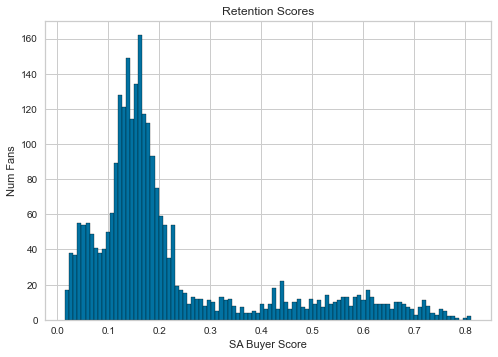

In [14]:
plt.hist(new_predictions["Score_1"], bins=100, edgecolor='black')
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.show()

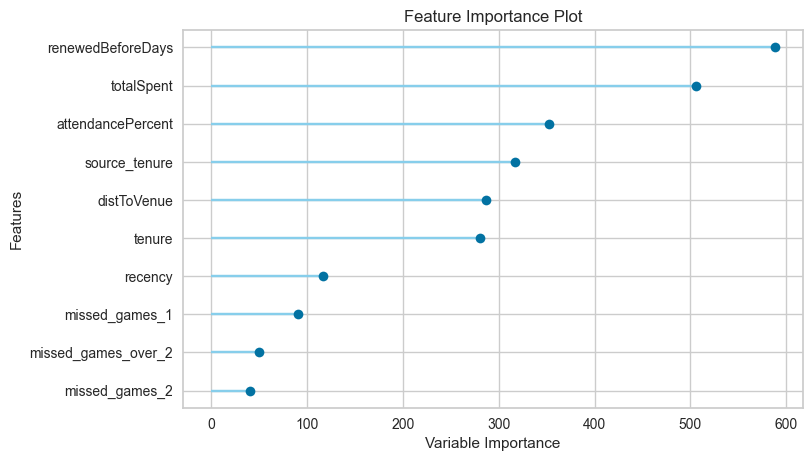

In [15]:
plot_model(best_model, plot='feature')

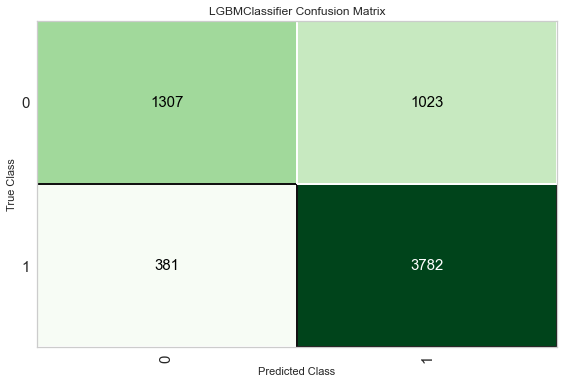

In [16]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above